Approach-1 Image and label dataset creation


Labels for approach-1:

1- Person

2 - Helmet

3 - Vest

In [1]:
# import necessary 
import os
import matplotlib.pyplot as plt
import cv2
import glob
import os
from PIL import Image
import random
import numpy as np
import PIL

In [2]:
# Create list of image names

image_dir = "/home/jaydeep/pictor-ppe/data/CHV_dataset/images/"
image_fps = glob.glob(os.path.join(image_dir, "*.jpg"))

Image re-size using PIL library

In [ ]:
# script to resize images to 960 x 544 pixels and save it a directory

count = 0
image_list = []
for image_fp in image_fps:

    image = image_fp.split('/')[-1]
    print(f'Image name: {image}\nImage shape: {imageShape(image)}\n')
    image_to_resize = Image.open(image_fp)
    image_to_resize.thumbnail((960,544), Image.ANTIALIAS)
    # plt.imshow(image_to_resize)
    resized_image_fp = os.path.join("/home/jaydeep/pictor-ppe/data/CHV_dataset/resized_images/images",image)
    image_to_resize.save(resized_image_fp, "JPEG")

In [39]:
# script to verify image sizes

resized_image_dir = "/home/jaydeep/pictor-ppe/data/CHV_dataset/resized_images/images"
resized_image_dir_fps = glob.glob(os.path.join(resized_image_dir, "*.jpg"))

image_height_toresize = []
image_width_toresize = []

for image_fp in resized_image_dir_fps:
    resized_image = cv2.imread(image_fp)
    img_height = resized_image.shape[0]
    img_width = resized_image.shape[1]
    if img_height > 544:
        image_height_toresize.append(image_fp)
    if img_width > 960:
        image_width_toresize.append(image_fp)
    # break

/home/jaydeep/pictor-ppe/data/CHV_dataset/images/ppe_0977.jpg
Original shape of image before resize
Width: 1024 Height: 683


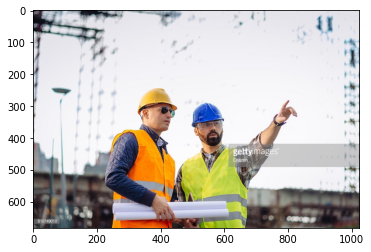

/home/jaydeep/pictor-ppe/data/CHV_dataset/resized_images/images/ppe_0977.jpg
Shape of image after resized to (w=960, h=544)
Width: 816 Height: 544


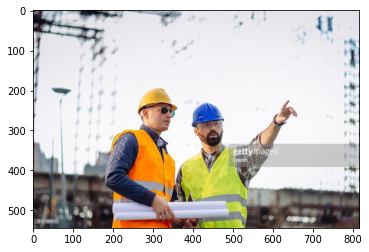

In [2]:
# Before resize
image_name = "ppe_0977.jpg"

img_path = "/home/jaydeep/pictor-ppe/data/CHV_dataset/images/"+image_name
# img_path = image_height_toresize[9]
print(img_path)
img = cv2.imread(img_path)
print("Original shape of image before resize")
print(f"Width: {img.shape[1]} Height: {img.shape[0]}")
plt.imshow(img[:, :, ::-1])
plt.show()


# After resize
img_path = "/home/jaydeep/pictor-ppe/data/CHV_dataset/resized_images/images/"+image_name
print(img_path)
img = cv2.imread(img_path)
print("Shape of image after resized to (w=960, h=544)")
print(f"Width: {img.shape[1]} Height: {img.shape[0]}")
plt.imshow(img[:, :, ::-1])
plt.show()

Below code section will be used to visualise image and generate kitti labels using the CHV data-set images

In [7]:
# This function will create image histograms to visualize images

def image_histogram_optimization(src_img):
    lab = cv2.cvtColor(src_img, cv2.COLOR_BGR2LAB)
    lightness, redness, yellowness = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8, 8))
    corrected_lightness = clahe.apply(lightness)
    limg = cv2.merge((corrected_lightness, redness, yellowness))
    adjusted = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return adjusted

In [3]:
annotations_dir = "/home/jaydeep/pictor-ppe/data/CHV_dataset/annotations/"
annotations_fps = glob.glob(os.path.join(annotations_dir, "*.txt"))

dataset_labels = {}

for annotation_fp in annotations_fps:

    with open(annotation_fp, 'r') as annotation_file:
        annotation_data = annotation_file.readlines()

        img_annotations = []

        for annotation in annotation_data:
            data = [float(i) for i in annotation.rstrip().split(" ")]
            data[0] = int(data[0])
            img_annotations.append(data)

        img_name = os.path.basename(annotation_fp).split(".")[0] + ".jpg"
        dataset_labels[img_name] = img_annotations

In [4]:
# Funtion to compute bounding box intersection over union

def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [5]:
# This functions helps to visualise images with ground truth labels
# We also convert the annotations from YOLO to KITTI format before inferring images

def visualise_examples(dataset_labels, image_name):

    for _ in range(1):

        # img_name, bbs = random.choice(list(dataset_labels.items()))

        img_name, bbs = image_name, dataset_labels[image_name]

        print(f"Image: {img_name} and Bounding box: {bbs}")
        img_fp = os.path.join("/home/jaydeep/pictor-ppe/data/CHV_dataset/resized_images/images",img_name)
        img = cv2.imread(img_fp)
        persons = []
        vests = []
        helmets = []

        # YOLO to KITTI format converter section
        for bb in bbs:


            w = (img.shape[1]*bb[3])/2
            h = (img.shape[0]*bb[4])/2

            x = img.shape[1]*bb[1]
            y = img.shape[0]*bb[2]

            x1 = int(x - w)
            y1 = int(y - h)
            x2 = int(x + w)
            y2 = int(y + h)

            if bb[0] == 0:
                # cv2.rectangle(img,(x1,y1),(x2,y2),(255,255,255),6)
                persons.append([x1,y1,x2,y2])
            elif bb[0] == 1:
                # cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),6)
                vests.append([x1,y1,x2,y2])
            else:
                helmets.append([x1,y1,x2,y2])


        persons_iou = [0.0]*len(persons)

        for i, person in enumerate(persons):
            for vest in vests:
                iou = bb_intersection_over_union(person, vest)

                if iou > persons_iou[i]:
                    persons_iou[i] = iou


        print(f'\nPersons : {persons}')
        print(f'Vests: {vests}')
        print(f'Helmets: {helmets}')

        # This section is used to visualise Person from an image frame
        for person in persons:
            mask = np.zeros(img.shape[:2], np.uint8)
            mask[person[1]:person[3], person[0]:person[2]] = 255

            color = ('b','g','r')
            for i,col in enumerate(color):
                img_ = image_histogram_optimization(img)
                histr = cv2.calcHist([img_],[i], mask,[256],[0,256])
                plt.plot(histr,color = col)
                plt.xlim([0,256])
            plt.show()
            masked_img = cv2.bitwise_and(img,img,mask = mask)
            plt.imshow(masked_img[:, :, ::-1])
            plt.show()

        # This section is used to vest from an image frame
        for vest in vests:
            mask = np.zeros(img.shape[:2], np.uint8)
            mask[vest[1]:vest[3], vest[0]:vest[2]] = 255

            color = ('b','g','r')
            for i,col in enumerate(color):
                img_ = image_histogram_optimization(img)
                histr = cv2.calcHist([img_],[i], mask,[256],[0,256])
                plt.plot(histr,color = col)
                plt.xlim([0,256])
            plt.show()
            masked_img = cv2.bitwise_and(img,img,mask = mask)
            plt.imshow(masked_img[:, :, ::-1])
            plt.show()

        # This section is used to visualise helmet from an image frame
        for helmet in helmets:
            mask = np.zeros(img.shape[:2], np.uint8)
            mask[helmet[1]:helmet[3], helmet[0]:helmet[2]] = 255

            color = ('b','g','r')
            for i,col in enumerate(color):
                img_ = image_histogram_optimization(img)
                histr = cv2.calcHist([img_],[i], mask,[256],[0,256])
                plt.plot(histr,color = col)
                plt.xlim([0,256])
            plt.show()
            masked_img = cv2.bitwise_and(img,img,mask = mask)
            plt.imshow(masked_img[:, :, ::-1])
            plt.show()


Image: ppe_0001.jpg and Bounding box: [[5, 0.307, 0.188859, 0.114, 0.133152], [4, 0.462, 0.137228, 0.1, 0.116848], [5, 0.701, 0.29212, 0.094, 0.089674], [0, 0.281, 0.527174, 0.21, 0.847826], [0, 0.468, 0.486413, 0.184, 0.891304], [0, 0.733, 0.591033, 0.242, 0.769022]]

BBox: [5, 0.307, 0.188859, 0.114, 0.133152]

Image shape: (368, 500, 3)
Width = 28.5
 Height = 24.499968

x = 153.5
 y = 69.500112

125 45 182 94

BBox: [4, 0.462, 0.137228, 0.1, 0.116848]

Image shape: (368, 500, 3)
Width = 25.0
 Height = 21.500031999999997

x = 231.0
 y = 50.499903999999994

206 28 256 71

BBox: [5, 0.701, 0.29212, 0.094, 0.089674]

Image shape: (368, 500, 3)
Width = 23.5
 Height = 16.500016000000002

x = 350.5
 y = 107.50016

327 91 374 124

BBox: [0, 0.281, 0.527174, 0.21, 0.847826]

Image shape: (368, 500, 3)
Width = 52.5
 Height = 155.99998399999998

x = 140.5
 y = 194.000032

88 38 193 350

BBox: [0, 0.468, 0.486413, 0.184, 0.891304]

Image shape: (368, 500, 3)
Width = 46.0
 Height = 163.999936

x

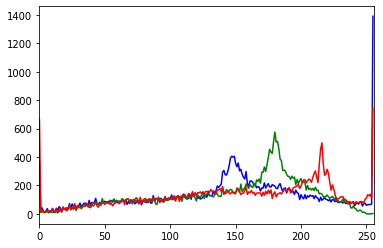

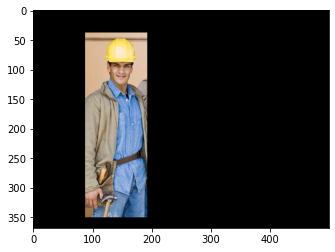

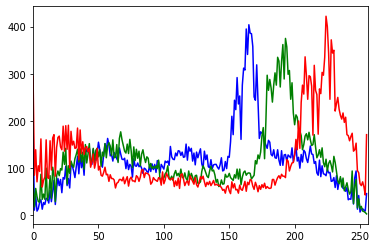

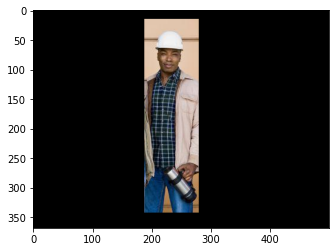

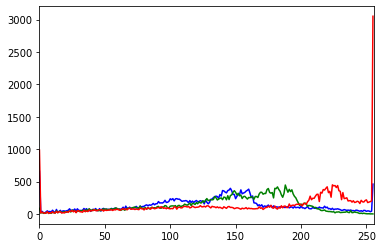

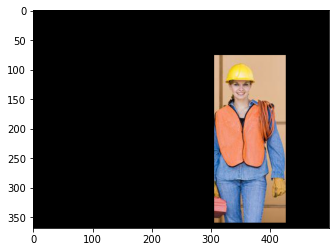

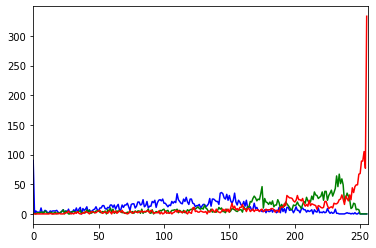

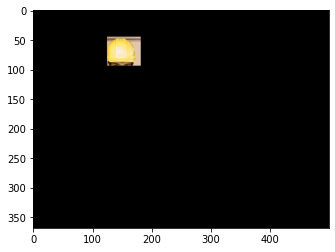

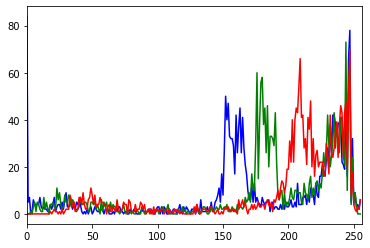

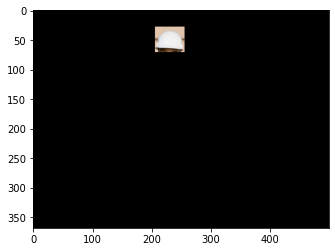

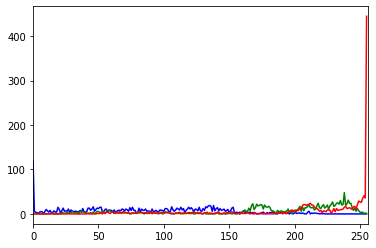

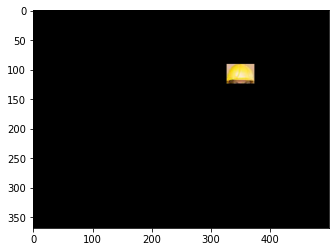

In [8]:
visualise_examples(dataset_labels,'ppe_0001.jpg')

Below script section will convert annotations from YOLO to KITTI and save it in a separate directory

In [ ]:
annotations_dir = "/home/jaydeep/pictor-ppe/data/CHV_dataset/annotations/"
annotations_fps = glob.glob(os.path.join(annotations_dir, "*.txt"))

dataset_labels = {}

for annotation_fp in annotations_fps:

    label_file_name = annotation_fp.split("/")[-1]
    print(f'Label file name: {label_file_name}')
    print(f'Annotation file: {annotation_fp}')
    image_fp = os.path.join("/home/jaydeep/pictor-ppe/data/CHV_dataset/images", label_file_name.replace('txt','jpg'))
    print(f'Image file: {image_fp}')
    img = cv2.imread(image_fp)
    
    with open(annotation_fp, 'r') as annotation_file:
        annotation_data = annotation_file.readlines()

        img_annotations = []
        n_line = [0] * 15
        str1 = ' '
        strf = ''
        list2 = []

        for annotation in annotation_data:
            data = [float(i) for i in annotation.rstrip().split(" ")]
            data[0] = int(data[0])
            img_annotations.append(data)

            if data[0] == 0:
                n_line[0] = 'person'
            elif data[0] == 1:
                n_line[0] = 'vest'
            else:
                n_line[0] = 'helmet'

            # YOLO to KITTI converter section
            print(f'\nBBox: {data}\n')
            w = (img.shape[1]*data[3])/2
            h = (img.shape[0]*data[4])/2
            print(f'Image shape: {img.shape}')
            print(f'Width = {w}\n Height = {h}\n')
            x = img.shape[1]*data[1]
            y = img.shape[0]*data[2]
            print(f'x = {x}\n y = {y}\n')
            x1 = int(x - w)
            y1 = int(y - h)
            x2 = int(x + w)
            y2 = int(y + h)
            print(x1,y1,x2,y2)
            
            n_line[4] = float(x1)
            n_line[5] = float(y1)
            n_line[6] = float(x2)
            n_line[7] = float(y2)
            str1 = ' '.join(str(n_line)).replace(' ', '').replace(',', ' ').replace('[', '').replace("]","").replace("'","").replace('"',"")
            strf = strf + str1 + "\n"

        strf=strf.replace("\n ","\n")
        # print(strf)
        with open('/home/jaydeep/pictor-ppe/data/CHV_dataset/KITTI_data/'+label_file_name, 'w') as fp:
            fp.write(strf)
        
            

        # img_name = os.path.basename(annotation_fp).split(".")[0] + ".jpg"
        # dataset_labels[img_name] = img_annotations


Visualising a sample image and ground truth label file

In [28]:
def draw_examples(image_name):
    # path 
    path = "/home/jaydeep/pictor-ppe/data/CHV_dataset/"
    image_path = os.path.join(path, "images", image_name)
    label_path = os.path.join(path, "kitti_label_annotations", image_name.replace('jpg','txt'))
    
    # Reading an image in default mode
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    print(f'Image shape: {image.shape}')
    
    # Reading labels
    with open(label_path, "r") as fp:
        lines = fp.readlines()
    thickness = 10
    print(lines)
    bbox0 = lines[0].strip().split(' ')
    start_point0 = (int(bbox0[4]), int(bbox0[5]))
    end_point0 = (int(bbox0[6]), int(bbox0[7]))
    color0 = (255, 0, 0)
    print(f'Bbox0: {start_point0,end_point0}')

    if len(lines) > 1:
        bbox1 = lines[1].strip().split(' ')

        start_point1 = (int(bbox1[4]), int(bbox1[5]))
        end_point1 = (int(bbox1[6]), int(bbox1[7]))
        color1 = (0, 0, 255)
        print(f'Bbox1: {start_point1,end_point1}')
        image1 = cv2.rectangle(image, start_point1, end_point1, color1, thickness)
    
    if len(lines) > 2:
        bbox1 = lines[2].strip().split(' ')

        start_point2 = (int(bbox1[4]), int(bbox1[5]))
        end_point2 = (int(bbox1[6]), int(bbox1[7]))
        color2 = (0, 255, 0)
        print(f'Bbox1: {start_point2,end_point2}')
        image1 = cv2.rectangle(image, start_point2, end_point2, color2, thickness)
    
    image0 = cv2.rectangle(image, start_point0, end_point0, color0, thickness)
    # print(f
    
    # Displaying the image 
    plt.imshow(image)

Image shape: (533, 800, 3)
['helmet 0 0 0 466 23 647 138 0 0 0 0 0 0 0\n', 'helmet 0 0 0 347 57 497 163 0 0 0 0 0 0 0\n', 'person 0 0 0 476 23 691 521 0 0 0 0 0 0 0\n', 'person 0 0 0 321 63 529 527 0 0 0 0 0 0 0\n']
Bbox0: ((466, 23), (647, 138))
Bbox1: ((347, 57), (497, 163))
Bbox1: ((476, 23), (691, 521))


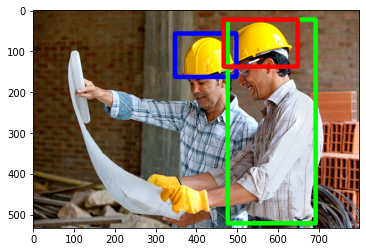

In [30]:
draw_examples('ppe_0028.jpg')

References:

- https://automaticaddison.com/how-to-apply-a-mask-to-an-image-using-opencv/ 

- https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

- https://github.com/zarar7576/YOLO_TO_KITTI  